## FHE enhanced Federated Learning for medical image data

This notebook provides an example of using FHE enhanced Federated learning for training a ResNet18 model on medical images. Note that it is a stand-alone example used to illustrate the concepts by simulation on a single server and that it does not distribute data over multiple nodes. It also presents some simple numerical investigations and benchmarking of operations in TenSEAL CKKS library.


In [1]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

from torchsummary import summary

import random
from torch.utils.data import Subset

import subprocess

import tenseal as ts
from time import time
import pandas as pd

print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")


MedMNIST v2.2.3 @ https://github.com/MedMNIST/MedMNIST/


In [2]:
# set some parameters

#data_flag = 'pathmnist'
#data_flag = 'breastmnist'
data_flag = 'dermamnist'

scheme = ["plain", "ckks"][1]
n_parts = 2
poly_choice = 0
N_rounds = 2 # 100

print(f"scheme: {scheme}, n_parts: {n_parts}, poly_choice: {poly_choice}")

download = True

NUM_EPOCHS = 5
BATCH_SIZE = 64
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])
print(f"n_channels: {n_channels}, n_classes: {n_classes}")

DataClass = getattr(medmnist, info['python_class'])


scheme: ckks, n_parts: 2, poly_choice: 0
n_channels: 3, n_classes: 7


In [3]:
# cryptographic parameters

if scheme=="ckks":
    param = [4096,8192][poly_choice]
    if param==4096:
        poly_mod_degree = 4096
        coeff_mod_bit_sizes = [40, 20, 40]
        context = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
        context.global_scale = 2 ** 20
    else:
        poly_mod_degree = 8192
        #coeff_mod_bit_sizes = [40, 21, 21, 21, 21, 21, 21, 40]
        coeff_mod_bit_sizes = [60,40,40,60]
        context = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
        #context.global_scale = 2 ** 21
        context.global_scale = 2 ** 40
    # this key is needed for doing dot-product operations
    context.generate_galois_keys()
    addition_tree = lambda parts: addition_tree_ckks(parts, context)
    max_vec_length = param//2
    model_name = f"ckks_{param}"

else:
    addition_tree = addition_tree_plain
    max_vec_length = 10000000000000000
    model_name = f"plain_text"
    
print(model_name)
    

ckks_4096


### read the MedMNIST data, preprocess and encapsulate  into dataloader

In [4]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)


Using downloaded and verified file: /root/.medmnist/dermamnist.npz
Using downloaded and verified file: /root/.medmnist/dermamnist.npz
Using downloaded and verified file: /root/.medmnist/dermamnist.npz


In [5]:
print(train_dataset)
print("===================")
print(test_dataset)


Dataset DermaMNIST (dermamnist)
    Number of datapoints: 7007
    Root location: /root/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'actinic keratoses and intraepithelial carcinoma', '1': 'basal cell carcinoma', '2': 'benign keratosis-like lesions', '3': 'dermatofibroma', '4': 'melanoma', '5': 'melanocytic nevi', '6': 'vascular lesions'}
    Number of samples: {'train': 7007, 'val': 1003, 'test': 2005}
    Description: The DermaMNIST is based on the HAM10000, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. The dataset consists of 10,015 dermatoscopic images categorized as 7 different diseases, formulized as a multi-class classification task. We split the images into training, validation and test set with a ratio of 7:1:2. The source images of 3×600×450 are resized into 3×28×28.
    License: CC BY-NC 4.0
Dataset DermaMNIST (dermamnist)
    Number of datapoints: 2005
    Root location: /

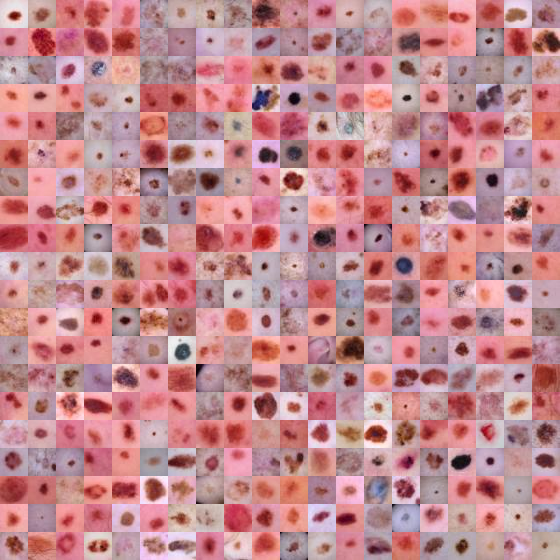

In [6]:
train_dataset.montage(length=20)


### partition training data over federation

In [7]:
n_subset = int(len(train_dataset)/n_parts)+1

idxs = list(range(len(train_dataset)))
random.shuffle(idxs)

print(len(train_dataset), len(idxs), n_subset, n_subset*n_parts)

subsets = [Subset(train_dataset, idxs[i*n_subset:(i+1)*n_subset]) for i in range(n_parts)] 
loaders = [data.DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True) for dataset in subsets]

print(n_parts, len(loaders))


7007 7007 3504 7008
2 2


### model and training configuration 

We define a simple model for illustration, object function and optimizer that we use to classify.

In [8]:
from torchvision.models import resnet18, mobilenet_v3_small, mnasnet1_3
from torch import nn

def init():
    #model = resnet18(num_classes=n_classes) # MNIST has 10 classes
    model = resnet18(num_classes=n_classes) # MNIST has 10 classes
    for i, param in enumerate(model.parameters()):
        pass

    model_length = i
    for i, param in enumerate(model.parameters()):
        if i < model_length - 1:
            param.requires_grad = False
            
    if task == "multi-label, binary-class":
        criterion = nn.BCEWithLogitsLoss()
    else:
        criterion = nn.CrossEntropyLoss()

    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    return model, criterion, optimizer


### utility and aggregation functions

We need these to aggregate model updates for the federation.


In [9]:
#state_dict = model.state_dict()

def flatten_trainable(model):
    all_trainable = []
    state_dict = model.state_dict().copy()
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: 
            continue
        no_params = parameter.numel()
        #print(name, no_params)
        all_trainable += state_dict[name].flatten().tolist()
    return all_trainable

def reshape_trainable(model, all_trainable):
    state_dict = model.state_dict().copy()
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: 
            continue
        n = parameter.numel()
        #print(name, n)
        this_param, all_trainable = all_trainable[:n], all_trainable[n:]
        this_shape = state_dict[name].shape
        state_dict[name] = torch.tensor(this_param).reshape(this_shape)
    return state_dict

#trainable_params = flatten_trainable(model)
#print(len(trainable_params))

#test = reshape_trainable(model, trainable_params)
#for name, parameter in model.named_parameters():
#    print((test[name] == state_dict[name]).all())


In [10]:
def addition_tree_plain(parts):
    #print("addition_tree_plain")
    n = len(parts)
    times = [-1,-1,-1,-1]
    if n==1:
        return times, parts[0]
    else:
        return times, addition_tree_plain(parts[:n//2])[1] + addition_tree_plain(parts[n//2:])[1] 

def addition_tree_ckks(vecs, context):
    #print("addition_tree_ckks")
    n_vectors = len(vecs)
    t0 = time()
    vecs_enc = [ts.ckks_vector(context, v) for v in vecs]
    enc_time = (time()-t0)/n_vectors
    t0 = time()
    _, aggr_enc = addition_tree_plain(vecs_enc)
    add_time = (time()-t0)
    t0 = time()
    aggr_vec = aggr_enc.decrypt()
    dec_time = (time()-t0)
    return (-1, enc_time, add_time, dec_time), aggr_vec

testlist = [1,2,3,4]
#addition_tree_plain(testlist)
#addition_tree_ckks([torch.tensor([a]) for a in testlist], context)
#addition_tree_ckks([np.array([a]) for a in testlist], context)
#addition_tree_ckks([[a] for a in testlist], context)


### Start to train and evaluate

In [11]:
def train_distr(verbose = False):

    model, criterion, optimizer = init()
    global_state = model.state_dict().copy()

    for epoch in range(NUM_EPOCHS):
        if verbose: print(f"epoch: {epoch+1}")
        params = []

        for i in range(n_parts):
            if verbose: print(f"part: {i+1}")
            model.load_state_dict(global_state.copy())
            model.train()
             
            for inputs, targets in loaders[i]:
                # forward + backward + optimize
                optimizer.zero_grad()
                outputs = model(inputs)
                if task == 'multi-label, binary-class':
                    targets = targets.to(torch.float32)
                    loss = criterion(outputs, targets)
                else:
                    targets = targets.squeeze().long()
                    loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

            trainable_params = flatten_trainable(model)        
            n_chunks = int(np.ceil((len(trainable_params)/max_vec_length)))
            params.append(np.array_split(trainable_params, n_chunks))

        aggr_params = []
        for j in range(n_chunks):
            times, aggr_chunk = addition_tree([params[i][j] for i in range(n_parts)])
            aggr_params.append(aggr_chunk)
        aggr_params = np.concatenate(aggr_params)/n_parts

        global_state = reshape_trainable(model, list(aggr_params))
        
    model.load_state_dict(global_state.copy())
    
    return [t*n_chunks for t in times], model
    
times, model = train_distr(verbose = False)

print('==> Training ...') 
print('train  enc: %.3f add:%.3f dec:%.3f' % tuple(times[1:]))


==> Training ...
train  enc: 0.004 add:0.000 dec:0.001


In [12]:
# evaluation

def test(split, model):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])
    
    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()
        
        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)
    return metrics
        
print('==> Evaluating ...')

metrics = test('train', model)
print('train  auc: %.3f  acc:%.3f' % metrics)

metrics = test('test', model)
print('test  auc: %.3f  acc:%.3f' % metrics)


==> Evaluating ...
train  auc: 0.821  acc:0.695
test  auc: 0.783  acc:0.684


## Collect stats for training and evaluation

In [13]:
tst = []

for i in range(N_rounds):
    row = model_name.split("_")
    row.append(n_parts)
            
    t0 = time()
    times, model = train_distr(verbose=False)
    row.append(time()-t0)

    accuracy = test('test', model)[1]
    row.append(accuracy)
    
    #row.append(times[0])
    row.append(times[1])
    row.append(times[2])
    row.append(times[3])
    
    tst.append(row)
    if N_rounds <= 10 or i%(N_rounds//10)==0 or i == N_rounds-1:
        print(f"Round {i+1} completed in {time()-t0}")

res = pd.DataFrame(tst, columns=["model", "param", "n_parts", "crypt_time","crypt_acc","enc_time","add_time","dec_time"])
res

Round 1 completed in 19.31236171722412
Round 2 completed in 20.17619228363037


,model,param,n_parts,crypt_time,crypt_acc,enc_time,add_time,dec_time
0,ckks,4096,2,18.477151,0.687282,0.004632,0.000110,0.001122
1,ckks,4096,2,19.353655,0.685287,0.004400,0.000082,0.001132


In [14]:
tmp = res.describe()
tmp.to_csv(f"figs/stats_{data_flag}_{model_name}_{n_parts}_{N_rounds}.csv")
tmp


,n_parts,crypt_time,crypt_acc,enc_time,add_time,dec_time
count,2.0,2.000000,2.000000,2.000000,2.000000,2.000000
mean,2.0,18.915403,0.686284,0.004516,0.000096,0.001127
std,0.0,0.619782,0.001411,0.000164,0.000020,0.000007
min,2.0,18.477151,0.685287,0.004400,0.000082,0.001122
25%,2.0,18.696277,0.685786,0.004458,0.000089,0.001125
50%,2.0,18.915403,0.686284,0.004516,0.000096,0.001127
75%,2.0,19.134529,0.686783,0.004574,0.000103,0.001130
max,2.0,19.353655,0.687282,0.004632,0.000110,0.001132


In [15]:
res.to_csv(f"figs/results_{data_flag}_{model_name}_{n_parts}_{N_rounds}.csv")
